# 1. Теория

## 1

Пусть в лист попали объекты $\{X_i\}$ с значениями на них $\{y_i\}$. Хотим сравнить матожидания $MSE$ для оценки $\xi = \frac{1}{n} \sum_{i=1}^{n}y_i$ и $\eta = y_{\theta}$ где $\theta$ - дискретное равномерное распределение.

Пусть $y^*$ - одна из двух оценок.

$E\sum_{i=1}^{n}(y_i - y^*)^2 = \sum_{i=1}^{n}E{y_i^2} - 2nEy_i y^* + \sum_{i=1}^{n}{y^*}^2$

Первое слагаемое не зависит от оценки, вторые совпадают, так как $E\eta = E\xi = \frac{1}{n} \sum_{i=1}^{n}y_i$. Третье слагаемое в случае $\xi$ будет $(\frac{1}{n} \sum_{i=1}^{n}y_i)^2$, а в случае $\eta$ это $E\eta^2 \geq (E\eta)^2 = (\frac{1}{n} \sum_{i=1}^{n}y_i)^2$. 

Получается, что выгоднее брать $\xi$.


# 2. Применение решающего дерева

In [36]:
import pandas as pd

In [37]:
data = pd.read_csv('../data/german.data-numeric', sep='\W+', header=None)

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X.head()

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,6,4,12,5,5,3,4,1,67,...,1,0,0,1,0,0,1,0,0,1
1,2,48,2,60,1,3,2,2,1,22,...,1,0,0,1,0,0,1,0,0,1
2,4,12,4,21,1,4,3,3,1,49,...,1,0,0,1,0,0,1,0,1,0
3,1,42,2,79,1,4,3,4,2,45,...,1,0,0,0,0,0,0,0,0,1
4,1,24,3,49,1,3,3,4,4,53,...,1,1,0,1,0,0,0,0,0,1


In [38]:
from sklearn import tree

model = tree.DecisionTreeClassifier(max_depth=3)
model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

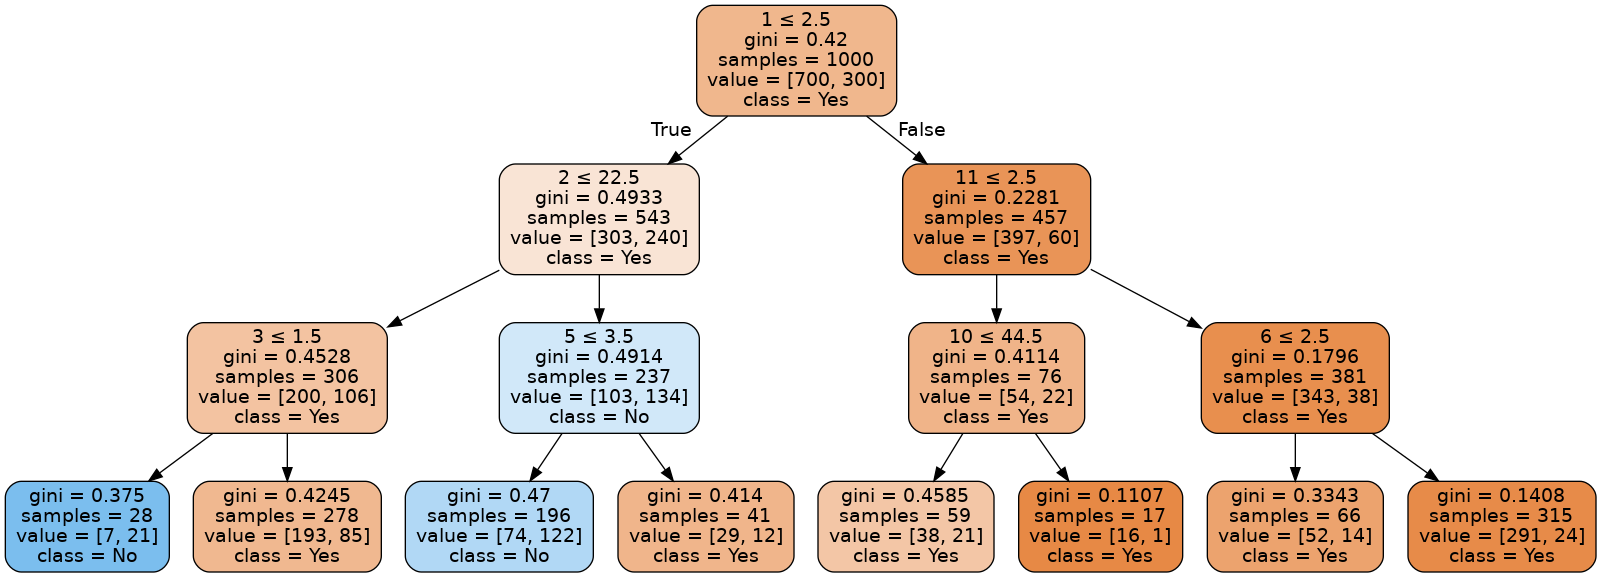

In [39]:
import pydotplus
from IPython.display import Image

dot_data = tree.export_graphviz(model, out_file="tree.out", 
                                feature_names=range(1, 25),
                                class_names=['Yes', 'No'],
                                filled=True, rounded=True,  
                                special_characters=True)
graph = pydotplus.graphviz.graph_from_dot_file("tree.out")
Image(graph.create_png())

**Признак 1:** Баланс счета за последний год. Логично, что если он большой, то можно выдавать кредит.

**Признак 2:** Срок кредита в месяцах (нужно для следующего листа)

**Признак 5:** Текущее состояние счета. Если денег мало, причем кредит выдается на большой срок, то может не отдать.

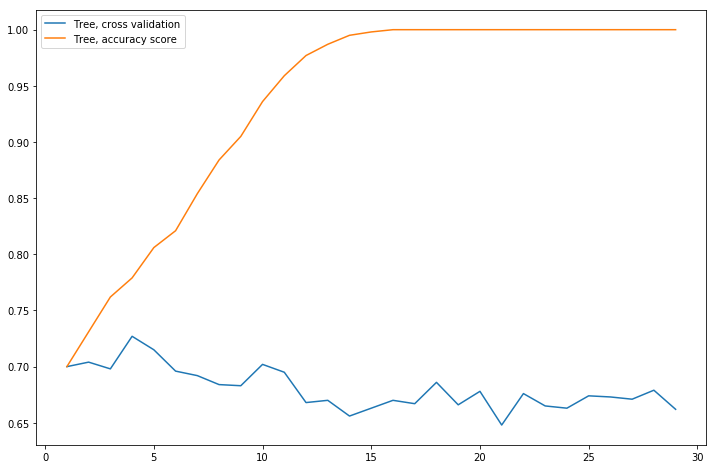

In [41]:
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

N = 30
cv = [cross_val_score(tree.DecisionTreeClassifier(max_depth=d, max_features=int(X.shape[1] ** 0.5)), 
                      X, y, cv=5).mean() for d in range(1, N)]
score = [accuracy_score(tree.DecisionTreeClassifier(max_depth=d).fit(X, y).predict(X), y) for d in range(1, N)]

plt.figure(figsize=(12, 8))
plt.plot(range(1, N), cv, label='Tree, cross validation')
plt.plot(range(1, N), score, label='Tree, accuracy score')
plt.legend(loc='upper left')
plt.show()

# 3. Реализация решающего дерева

В файле **decision_tree_regressor.py**, должен быть приложен.

In [42]:
from sklearn.datasets import load_boston, load_iris
from sklearn.model_selection import train_test_split
from decision_tree_regressor import DecisionTree
import numpy as np

boston = load_boston()

In [43]:
data = pd.DataFrame(boston.data)
data.columns = boston.feature_names
data['target'] = boston.target

In [44]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [55]:
X = data.iloc[:, :-1]
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1], data['target'], test_size=0.25)

In [56]:
model = DecisionTree()
model.fit(X_train, y_train)

/home/egiby/Learning/Current/Машинка/practice/hw2/decision_tree_regressor.py:11: RuntimeWarning: Mean of empty slice.
  y_mean = y.mean()
/usr/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/egiby/Learning/Current/Машинка/practice/hw2/decision_tree_regressor.py:13: RuntimeWarning: Mean of empty slice.
  return ((y - y_mean) ** 2).mean()


In [57]:
# Среднеквадратичное отклонение
def mse(y, y_test):
    return (((np.array(y) - np.array(y_test)) ** 2).mean()) ** 0.5

In [58]:
mse(model.predict(X_test), y_test)

8.4501264017797304

In [59]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [60]:
mse(model.predict(X_test), y_test)

5.5398200601835974